In this notebook we are going to train a classification model. The data is about a fictional vessel called Titanic whose full story can be found here <a href=https://www.kaggle.com/competitions/spaceship-titanic/overview > Spacesship Titanic </a>. The stated goal is 
> To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [233]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, jaccard_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [9]:
train_df = pd.read_csv('I:/My Drive/Colab Notebooks/All/data/spaceship_titanic/train.csv')
test_df = pd.read_csv('I:/My Drive/Colab Notebooks/All/data/spaceship_titanic/test.csv')

# Exploration

In [10]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
print(train_df.shape, test_df.shape)

(8693, 14) (4277, 13)


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Missing Values

In [134]:
train_df.fillna(value=10, inplace=True)
test_df.fillna(value=10, inplace=True)

## Categorical Variables

In [28]:
train_df.describe(include='object')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


Proper categorical variables are:
- HomePlanet
- CryoSleep
- Destination
- VIP.

The following are not categoricalm, they just have an `object` data type.
- PassengerId
- Name

### Label Encoding

We need to label our proper categorical variables with numeric labels so that we can pass it into a classification algorithm.

In [62]:
X_cat = train_df[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']].values
X_cat

array([['Europa', False, 'TRAPPIST-1e', False],
       ['Earth', False, 'TRAPPIST-1e', False],
       ['Europa', False, 'TRAPPIST-1e', True],
       ...,
       ['Earth', False, 'TRAPPIST-1e', False],
       ['Europa', False, '55 Cancri e', False],
       ['Europa', False, 'TRAPPIST-1e', False]], dtype=object)

Then we figure out the classes of these categorical variables so that we can fit them to numeric labels

In [76]:
for column in train_df[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']]:
    print(train_df[column].unique())

['Europa' 'Earth' 'Mars' nan]
[False True nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
[False True nan]


#### Missing Values


There are `NaN`s in all our columns so these may have to be filled properly.

In [79]:
train_df[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']].isnull().sum()

HomePlanet     201
CryoSleep      217
Destination    182
VIP            203
dtype: int64

In [84]:
LE = LabelEncoder()

In [ ]:
LE.fit(['Europa', 'Earth', 'Mars', '10'])
X_cat[:,0] = LE.transform(X_cat[:,0])

LE.fit(['True', 'False', '10'])
X_cat[:,1] = LE.transform(X_cat[:,1])

LE.fit(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', '10'])
X_cat[:,2] = LE.transform(X_cat[:,2])

LE.fit(['True', 'False', '10'])
X_cat[:,3] = LE.transform(X_cat[:,3])

In [104]:
X_cat

array([[1, 0, 2, 0],
       [0, 0, 2, 0],
       [1, 0, 2, 1],
       ...,
       [0, 0, 2, 0],
       [1, 0, 0, 0],
       [1, 0, 2, 0]], dtype=object)

### Numerical Variables

In [34]:
train_df.describe(include='float64')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


We need to normalize our numeric data types before using them in our models.

In [36]:
num_features = list(train_df.describe(include='float64').columns)

In [64]:
X = train_df[num_features]

SCALE = StandardScaler()
X_num = SCALE.fit_transform(X)

In [99]:
X_num

array([[ 0.70209482, -0.33702544, -0.28427377, -0.28731673, -0.27373585,
        -0.26609771],
       [-0.33323258, -0.17352835, -0.27868854, -0.24597123,  0.20926721,
        -0.22769155],
       [ 2.01350954, -0.27252659,  1.93492201, -0.28731673,  5.63403389,
        -0.22332722],
       ...,
       [-0.19518893, -0.33702544, -0.28427377,  2.8086338 , -0.27285607,
        -0.26609771],
       [ 0.21894203, -0.33702544,  0.36671515, -0.28731673,  0.03682896,
         2.55762723],
       [ 1.04720396, -0.1480288 ,  2.6250075 , -0.28731673, -0.27373585,
        -0.2556233 ]])

### Creating `X_train`


In [103]:
X_cat.shape

(8693, 4)

In [109]:
# Concatenating our same length arrays
X_train = np.hstack((X_num, X_cat))

## Functions for Our Work


It makes sense to standardize our cleaning operations since they apply both to the train and test set.

This section summarizes all the work done above.

In [142]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
def make_transforms (data):
    X_cat = data[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']].values
    X_cat

    LE = LabelEncoder()

    LE.fit(['Europa', 'Earth', 'Mars', '10'])
    X_cat[:,0] = LE.transform(X_cat[:,0])

    LE.fit(['True', 'False', '10'])
    X_cat[:,1] = LE.transform(X_cat[:,1])

    LE.fit(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', '10'])
    X_cat[:,2] = LE.transform(X_cat[:,2])

    LE.fit(['True', 'False', '10'])
    X_cat[:,3] = LE.transform(X_cat[:,3])

    X_cat

    num_features = list(data.describe(include='float64').columns)

    X = data[num_features]
    
    SCALE = StandardScaler()
    X_num = SCALE.fit_transform(X)

    X_num
    
    # Concatenating our same length arrays
    X_train = np.hstack((X_num, X_cat))
    
    return X_train


# Model Building

### Test Train Split

In [143]:
X = make_transforms(train_df)
y = train_df['Transported']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Decision Trees


## Training


In [211]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

In [212]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [213]:
clf.score(X_train, y_train)

0.7686309599897737

In [214]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

       False       0.82      0.68      0.75      3882
        True       0.73      0.85      0.79      3941

    accuracy                           0.77      7823
   macro avg       0.78      0.77      0.77      7823
weighted avg       0.78      0.77      0.77      7823



We may have to introduce something like cross validation to get our accuracy higher

## Cross Validation


In [215]:
scores = cross_val_score(clf, X_train, y_train, cv=10)

Text(0.5, 1.0, 'Decision Tree Cross Validation')

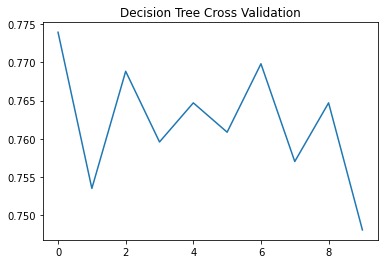

In [232]:
sns.lineplot(x=range(10), y=scores)
plt.title("Decision Tree Cross Validation")

### Hyperparameter Tuning


In [240]:
param_grid = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['gini', 'entropy']}
tree = DecisionTreeClassifier()
clf = GridSearchCV(tree, param_grid, cv=5)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.7970088201457242

Cross validation has marginally increased our performance by about 3 percentage points.

## Out-of-Sample Accuracy


In [241]:
y_hat = clf.predict(X_test)

In [242]:
jaccard_score(y_test, y_hat, pos_label=1)

0.6635859519408502

In [243]:
confusion_matrix(y_test, y_hat, labels=[0,1])

array([[329, 104],
       [ 78, 359]], dtype=int64)

In [244]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.81      0.76      0.78       433
        True       0.78      0.82      0.80       437

    accuracy                           0.79       870
   macro avg       0.79      0.79      0.79       870
weighted avg       0.79      0.79      0.79       870



## Conclusion


Adjusting the `max_depth=` parameter in `DecisionTreeClassifier` upwards results in overfitting. We get progressively higher in sample accuracy while out of sample accuracy stagnates or goes down. We now need to try another algorithm

# K-Nearest Neighbours


## Training

This ia another classification algorithm.

In [222]:
KNN = KNeighborsClassifier()

In [223]:
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [224]:
KNN.score(X_train, y_train)

0.826025821296178

## Cross Validation


In [229]:
k_folds = 5
scores2 = cross_val_score(KNN, X_train, y_train, cv=k_folds)

Text(0.5, 1.0, 'KNN Cross Validation')

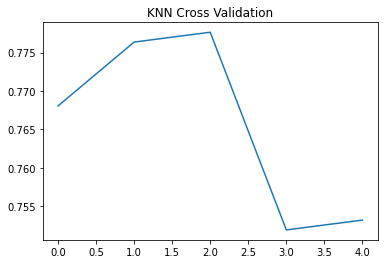

In [231]:
sns.lineplot(x=range(k_folds), y=scores2)
plt.title("KNN Cross Validation")

### Hyperparameter Tuning

In [245]:
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn = KNeighborsClassifier()
clf_knn = GridSearchCV(knn, param_grid, cv=5)
clf_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [246]:
clf_knn.score(X_train, y_train)

0.826025821296178

Our model accuracy has not been improved by use of cross validation so we proceed with it as is.

## Out-of-Sample Accuracy


In [247]:
y_hat = clf_knn.predict(X_test)

In [248]:
jaccard_score(y_test, y_hat, pos_label=1)

0.6175373134328358

In [249]:
confusion_matrix(y_test, y_hat, labels=[0,1])

array([[334,  99],
       [106, 331]], dtype=int64)

In [250]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.76      0.77      0.77       433
        True       0.77      0.76      0.76       437

    accuracy                           0.76       870
   macro avg       0.76      0.76      0.76       870
weighted avg       0.76      0.76      0.76       870



## Conclusions


The KNN model has a lower `f1 score` and even lower `jaccard score` than our decision tree model. 

Our response for now is to prefer the decision tree to this particular model.

# Logistic Regression


## Training

In [251]:
from sklearn.linear_model import LogisticRegression

In [257]:
LR = LogisticRegression(C=0.01, solver='liblinear')

LR.fit(X_train, y_train)
y_hat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

In [258]:
LR.score(X_train, y_train)

0.767736162597469

## Cross Validation

In [259]:
k_folds = 5
scores3 = cross_val_score(LR, X_train, y_train, cv=k_folds)

Text(0.5, 1.0, 'KNN Cross Validation')

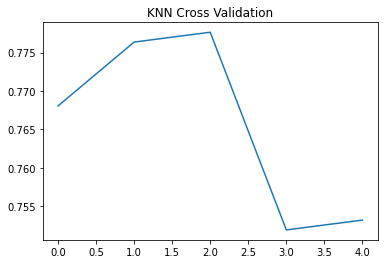

In [260]:
sns.lineplot(x=range(k_folds), y=scores2)
plt.title("KNN Cross Validation")

### Hyperparameter Tuning


In [263]:
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10], 'solver': ['liblinear'], 'max_iter': [100, 1000]}
logreg = LogisticRegression()
clf_lr = GridSearchCV(logistic, param_grid, cv=5)
clf_lr.fit(X_train, y_train)
clf_lr.score(X_train, y_train)

0.77924070049853

## Out-of-Sample Accuracy


In [264]:
y_hat = clf_lr.predict(X_test)

In [265]:
jaccard_score(y_test, y_hat, pos_label=1)

0.6709796672828097

In [266]:
confusion_matrix(y_test, y_hat, labels=[0,1])

array([[329, 104],
       [ 74, 363]], dtype=int64)

In [267]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.82      0.76      0.79       433
        True       0.78      0.83      0.80       437

    accuracy                           0.80       870
   macro avg       0.80      0.80      0.80       870
weighted avg       0.80      0.80      0.80       870



## Conclusions


The Logistic Regression model has performed the best out of all the three we have tried so far. It has a conservative in sample accuracty (0.78) yet its out of sample scores are even better,

It has the highest `jaccard score` and `f1 score`, the latter breeching 0.80. 

This is our winning model thus far.

# Exporting Predictions


We now make predictions on the unlabelled test set provided to us from Kaggle and save them to file in the appropriate format.

In [269]:
X_test_kaggle = make_transforms(test_df)

In [274]:
y_hat_kaggle = clf_lr.predict(X_test_kaggle)

In [273]:
test_df.PassengerId

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object

In [276]:
kaggle_df = pd.DataFrame({'PassengerId' : test_df.PassengerId, 'Transported' : y_hat_kaggle})

In [277]:
kaggle_df.to_csv("./data/spaceship_titanic/predictions.csv", index=False)